In [63]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import sys 
sys.path.append("../../core-scripts")
from linStabSpectrum import spectrum
from cheb import cheb
chebfit = np.polynomial.chebyshev.Chebyshev.fit

In [3]:
import numpy as np
from scipy.linalg import eig
import numpy as np
from cheb import cheb

##------------------------------------
def spectrum(k,_gd,_tau,_a,_ell_over_W_squared=0.01, M=50):
	"""Takes in a set of parameters and returns the spectrum that 
	corresponds to these parameter values.

	Args:
		k (float): wavenumber
		_gammadot (float): external shear rate
		_tau (float): liquid crystal relaxation time
		_tau_a (float): activity time scale

	Returns:
		list[complx numbers]: a (cleaned of any infinities) list of eigenvalues
	"""
	# M is the resolution

	# parameters 
	_llambda = 1.0
	_eta = 1.0
	_aux_const = 1 + (_gd*_tau)**2
	_tmp_const = k*k*_llambda / _aux_const 

	##------------------------------------

	II = np.identity(M,dtype='d')

	# Build Chebyshev differention matrix and the grid points on [-1, 1]
	D1, ygl = cheb(M)

	# let's just use [-1, 1] for simpliciy...
	# The factor 2 takes care of the domain being from -1/2 to 1/2
	# D1 = 2*D1

	D2 = np.dot(D1,D1)

	# Variable layout
	# psi[0:M] Qxx[M:2*M] Qxy[2*M:3*M] 
	Rpsi  = slice(0*M,1*M)
	RQxx  = slice(1*M,2*M)
	RQxy  = slice(2*M,3*M)

	LHS = np.zeros((3*M,3*M),dtype='D')

	# Stokes equation
	LHS[Rpsi, Rpsi] = (k**4*II - 2*(k**2)*D2 + np.dot(D2,D2))/_tau
	LHS[Rpsi,RQxx] = -2j*_a*k*D1/_eta
	LHS[Rpsi, RQxy] = -(_a*(k**2)*II + _a*D2)/_eta

	## Qxx equation
	LHS[RQxx,Rpsi] = (_tmp_const*(_gd*_tau) * II\
							- 2j*k*_llambda*D1 - (_llambda*_gd*_tau/_aux_const)*D2)
	LHS[RQxx,RQxx] = (1 + _ell_over_W_squared*k*k + 1j*k*ygl*_gd*_tau)*II - _ell_over_W_squared*D2
	LHS[RQxx,RQxy] = -_gd*_tau*II

	## Qxy equation
	LHS[RQxy,Rpsi] = (-_tmp_const*(1 + 2*(_gd*_tau)**2)*II)\
							- _llambda / _aux_const * D2
	LHS[RQxy,RQxx] = _gd*_tau*II
	LHS[RQxy,RQxy] = (1 + _ell_over_W_squared*k*k + 1j*k*ygl*_gd*_tau)*II - _ell_over_W_squared*D2

	RHS = np.zeros((3*M,3*M),dtype='D')
	RHS[RQxx,RQxx] = -_tau*II
	RHS[RQxy,RQxy] = -_tau*II

	## Boundary conditions
	LHS[0]     = np.zeros(3*M,dtype='D') # Psi vanishes at the boundaries
	LHS[1]     = np.zeros(3*M,dtype='D') # and dy(Psi) (?) vanishes at the boundaries
	LHS[M-2]   = np.zeros(3*M,dtype='D') # how does this code account for no-slip?
	LHS[M-1]   = np.zeros(3*M,dtype='D')

	LHS[0,0]      = 1.0
	LHS[1,Rpsi]   = D1[0]
	LHS[M-2,Rpsi] = D1[M-1]
	LHS[M-1,M-1]  = 1.0

	LHS[M]     = np.zeros(3*M,dtype='D') # dy(Qxx) vanishes at the boundaries
	LHS[2*M-1] = np.zeros(3*M,dtype='D')

	LHS[M,RQxx]     = D1[0]
	LHS[2*M-1,RQxx] = D1[M-1]

	LHS[2*M]   = np.zeros(3*M,dtype='D') # dy(Qxy) vanishes at the boundaries
	LHS[3*M-1] = np.zeros(3*M,dtype='D')

	LHS[2*M,RQxy]   = D1[0]
	LHS[3*M-1,RQxy] = D1[M-1]


	RHS[0]     = np.zeros(3*M,dtype='D')
	RHS[1]     = np.zeros(3*M,dtype='D')
	RHS[M-2]   = np.zeros(3*M,dtype='D')
	RHS[M-1]   = np.zeros(3*M,dtype='D')
	RHS[M]     = np.zeros(3*M,dtype='D')
	RHS[2*M-1] = np.zeros(3*M,dtype='D')
	RHS[2*M]   = np.zeros(3*M,dtype='D')
	RHS[3*M-1] = np.zeros(3*M,dtype='D')


	_spec = eig(LHS,RHS,left=0,right=1)

	_eig_list = _spec[0]
	finite_idx = np.where(np.isfinite(_eig_list))[0]
	_modes_list = _spec[1]

	# clean the eigenvalue list of all infinities
	clean_eig_list = _eig_list[finite_idx]
	clean_modes_list = _modes_list[finite_idx]
	return (clean_eig_list, clean_modes_list)

In [76]:
def plot_modes(idx, evec, M=50):
    _,ygl = cheb(M)
    Psi = evecs[idx][0:M]
    Qxx = evecs[idx][M:2*M]
    Qxy = evecs[idx][2*M:3*M]
    
    Re_Psi_fit = chebfit(ygl, np.real(Psi), M)
    Im_Psi_fit = chebfit(ygl, np.imag(Psi), M)
    Re_Qxx_fit = chebfit(ygl, np.real(Qxx), M)
    Im_Qxx_fit = chebfit(ygl, np.imag(Qxx), M)
    Re_Qxy_fit = chebfit(ygl, np.real(Qxy), M)
    Im_Qxy_fit = chebfit(ygl, np.imag(Qxy), M)
    
    yy = np.linspace(-1,1,400)
    fig, axs = plt.subplots(3,1)
    axs[0].plot(yy,Re_Psi_fit(yy))
    axs[0].plot(yy,Im_Psi_fit(yy))
    axs[0].title.set_text("$\Psi$")
    plt.legend(["Real","Imag"])
    
    axs[1].plot(yy,Re_Qxx_fit(yy))
    axs[1].plot(yy,Im_Qxx_fit(yy))
    axs[1].title.set_text("$Q_{xx}$")
    
    axs[2].plot(yy,Re_Qxy_fit(yy))
    axs[2].plot(yy,Im_Qxy_fit(yy))
    axs[2].title.set_text("$Q_{xy}$")
    
    for ax in axs.flat:
        ax.set(xlabel='$y$')

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()

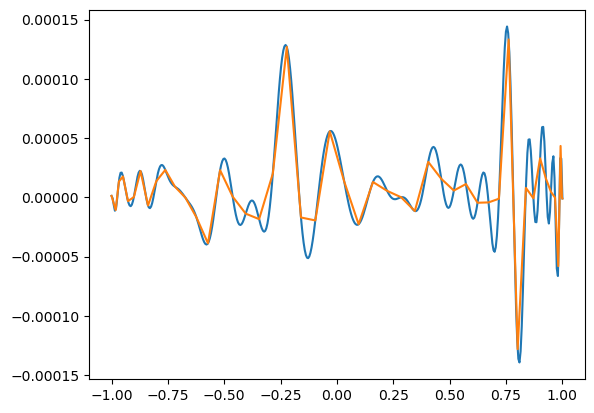

In [54]:
k,gd,tau,a = 3, 4, 1, 1.6
M=50
evals, evecs = spectrum(k,gd,tau,a) # M=50 by default!
_, ygl = cheb(M)
idx = 3
Psi = evecs[idx][0:M]
# plt.plot(ygl, np.real(Psi),marker='x',linestyle='--')
# plt.ylim(-1,1)
cheb_fit = np.polynomial.chebyshev.Chebyshev.fit(ygl, np.real(Psi), M)
yy = np.linspace(-1,1,400)
plt.plot(yy, cheb_fit(yy))
plt.plot(ygl, cheb_fit(ygl))

(-3.829842923987993-11.387186130411056j)


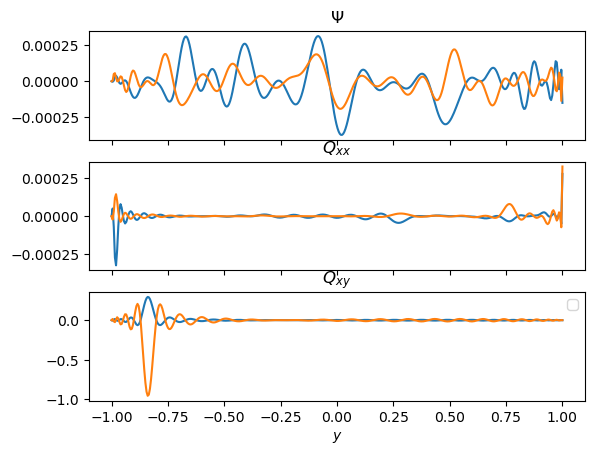

In [90]:
re_evals_sort_idx = np.argsort(-np.real(evals))
idx = re_evals_sort_idx[10]
print(evals[idx])
plot_modes(idx, evecs)

In [80]:
print(evals[re_evals_sort_idx])

[  -1.22419646 -6.68950759j   -1.22419647 +6.68950759j
   -1.75583406-14.97468083j   -1.75583406+14.97468083j
   -2.41094898 +4.45695624j   -2.41094902 -4.45695612j
   -2.82149221+13.08176101j   -2.82149224-13.08176104j
   -3.36868    -2.96558179j   -3.36868004 +2.9655818j
   -3.82984292-11.38718613j   -3.82984296+11.38718616j
   -4.14659322 +1.68658114j   -4.14659329 -1.68658154j
   -4.59301188+10.04165707j   -4.59301188-10.04165707j
   -4.85732925 +0.52621321j   -4.85732926 -0.52621318j
   -5.23940401 -8.79425961j   -5.23940403 +8.79425963j
   -5.6716106  +0.47980357j   -5.67161341 -0.47980331j
   -5.84378829 -7.69056695j   -5.84378852 +7.69056656j
   -6.26598894 -1.496211j     -6.2660164  +1.49619412j
   -6.38714602 -6.6579852j    -6.38714605 +6.65798527j
   -6.82846193 +2.4670697j    -6.82853453 -2.46705566j
   -6.92711304 -5.70039748j   -6.92711365 +5.70039925j
   -7.36789458 -3.50326191j   -7.36790699 +3.50326816j
   -7.38857573 +4.63464002j   -7.38858032 -4.63463611j
   -7.81036